Try to solve Hungry Geese Problem by Worldmodels model.

https://arxiv.org/abs/1803.10122 , Worldmodel paper arxiv, David Ha, Jürgen Schmidhuber 9 May 2018.

1. Make custom environment renderer to plot observation image of each steps for kaggle_environment


2. Make Rollout data for training VAE and MDN-RNN model. 

 Rollout data :{obs_img, reward, done, action} and z vector made by trained VAE
 
 Rollout data is made by 250 episode of simulation log with defensive_random_action agent 
 
 that moves randomly but try not to do actions that directly lead to death
 
 - scaling reward by (reward / max_reward)
 

3. Train VAE(Variational AutoEncoder) model by Rollout data. 

 VAE compresses the high-dimensional input image into a random variable in the latent space that follows a multivariate standard normal distribution.
 


4. Train MDN_RNN model by Rollout data with z vector for each steps.

 RNN part receives each step's Z vector, action, reward(sequential situation) to predict next step's z vector's distribution
 
 The last hidden state of RNN is used for training controller in real kaggle environment 
 
 MDN part receives RNN part's output and generate 5 mixed distribution of log_pi, mu, log_sigma to sample z vector, and reward
 
 The z vector sampled by MDN's output is used to train controller in dream (The real world observation replaced by MDN's z vector and reward)
 
  
5. Train Controller model in real world mode and dream mode

 Train controller by CMA evolution strategy in real world mode and dream mode.
 
 - The model's performance improvement could not be observed through the training of the evolutionary strategy.
 
 
6. Agent is composed of VAE, MDN-RNN, and Controller(trained by dream mode simulation) to return Action according to Observation.

 - The opposite action was forcibly prevented to keep minimum performance of agent.


In [ ]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

In [ ]:
%%write_and_run main.py 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, time, datetime
from IPython.display import clear_output
from os.path import join

# Function for Rendering observation Image(3x64x64) of each step

In [ ]:
%%write_and_run -a main.py 
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
def location(loc):
    row = 7
    column = 11
    return loc % column, loc // column

def custom_env_render(obs, row=7, column=11):
    txt = Image.new("RGBA", (column * 30,row * 30), (255, 255, 255))
    draw = ImageDraw.Draw(txt)
    grid_size = 30
    #draw grid
    for i in range(column):
        for j in range(row):
            x1 = i*grid_size
            y1 = j*grid_size
            x2 = (i+1)*grid_size
            y2 = (j+1)*grid_size
            draw.rectangle(((x1, y1), (x2, y2)), outline='black', width=3)
    
    for food_location in obs['food']:
        # draw foods
        x,y = location(food_location)
        draw.ellipse((x*grid_size, y*grid_size, (x+1)*grid_size, (y+1)*grid_size), fill = 'blue', outline ='blue')
        
    color_list = ['red', 'yellow', 'green', 'purple']
    for i, geese in enumerate(obs['geese']):
        for j, body in enumerate(geese):
            x,y = location(body)
            if j==0:
                #draw head
                draw.polygon([((x+1/2)*grid_size,y*grid_size),(x*grid_size,(y+1/2)*grid_size),
                              ((x+1/2)*grid_size,(y+1)*grid_size), ((x+1)*grid_size,(y+1/2)*grid_size)], fill = color_list[i])
            else:
                #draw body
                draw.rectangle(((x*grid_size, y*grid_size), ((x+1)*grid_size, (y+1)*grid_size)), fill=color_list[i], outline=color_list[i])

    txt = txt.resize((64, 64)).convert('RGB')
    numpy_image = np.array(txt)
    plt.axis("off")
    trans1 = transforms.ToTensor()
    tensor_image = trans1(numpy_image)
    
    return tensor_image

def custom_reward(obs):
    #reward = steps survived * (configuration.max_length + 1) + goose length
    
    # scaling reward to 0 ~ 1
    max_reward = 200 * (99 + 1) + 99
    steps_survived = obs['step']
    max_length = 99
    goose_length = len(obs['geese'][0])
    
    reward = (steps_survived * (max_length + 1) + goose_length) / max_reward
    
    return reward

# Testing Image Rendering function

In [ ]:
def defensive_random_action(prev_action, obs):
    # Agent that try to avoid death as much as possible and move randomly
    prohibition = set([])
    action_list = ['NORTH','SOUTH','WEST','EAST']
    num_action = len(action_list)
    row = 7
    column = 11
    geese = obs['geese']
    g_list = []
    for gs in geese:
        g_list.extend(gs)
    my_head = g_list.pop(0)
    myhead = location(my_head)
    
    for g in g_list:
        g = location(g)
        if g[0] == myhead[0] and (g[1] - myhead[1] == 1 or (g[1] == 0 and myhead[1] == row)):
            prohibition.add('SOUTH')
        if g[0] == myhead[0] and (g[1] - myhead[1] == -1 or (g[1] == row and myhead[1] == 0)):
            prohibition.add('NORTH')
        if g[1] == myhead[1] and (g[0] - myhead[0] == 1 or (g[0] == 0 and myhead[0] == column)):
            prohibition.add('EAST')
        if g[1] == myhead[1] and (g[0] - myhead[0] == -1 or (g[0] == column and myhead[0] == 0)):
            prohibition.add('WEST')
    if prev_action is not None:
        opposite_action = {'NORTH':'SOUTH' , 'SOUTH':'NORTH', 'EAST':'WEST', 'WEST':'EAST' }
        prohibition.add(opposite_action[prev_action])
    
    
    if len(prohibition) < num_action:
        action = random.choice([x for x in action_list if x not in prohibition])
    else:
        # no way to survive
        action = random.choice(action_list)
    return action

Blue Circle : Food

Rhombus : Geese's Head

Rectangle : Geese's Body

Red Geese : Player Geese

Yello, Green, Purple Geese : Rival Geese

In [ ]:
from kaggle_environments import make
import random
env = make("hungry_geese", debug=False)

# Training agent in first position (player 1) against the default random agent.
trainer = env.train([None, "greedy", "greedy", "greedy"])

obs = trainer.reset()
img = custom_env_render(obs, True)
print(obs)
prev_action = None
for _ in range(3):
    action = defensive_random_action(prev_action, obs)
    obs, reward, done, info = trainer.step(action)
    
    # change reward to custom reward
    reward = custom_reward(obs)
    prev_action = action
    img_tensor = custom_env_render(obs)
    tf = transforms.ToPILImage()
    img_t = tf(img_tensor)
    plt.imshow(img_t)
    plt.show()
    plt.close()
    print('obs :{}'.format(obs))
    print('reward :{}'.format(reward))
    print('done :{}'.format(done))
    if done:
        obs = trainer.reset()
        print('episode ended')
        break

# Make Dataset by Rollout

In [ ]:
total_episodes = 250
time_steps = 200

In [ ]:
class Rollout():
    def __init__(self, data_dic, dir_name):
        super().__init__()
        self.data_dic = data_dic
        self.dir_name = dir_name
        
    def make_rollout(self):
        if not os.path.exists(self.dir_name):
            os.makedirs(self.dir_name)

        env = make("hungry_geese", debug=False)

        trainer = env.train([None, "greedy", "greedy", "greedy"])
        s = 0
        start_time = time.time()
        while s < total_episodes:
            obs_sequence = []
            action_sequence = []
            reward_sequence= []
            done_sequence = []
            img_tensor_sequence = []
            obs = trainer.reset()
            img = custom_env_render(obs, True)
            prev_action = None
            for t in range(time_steps):
                env.render()
                action = defensive_random_action(prev_action, obs)
                obs, reward, done, info = trainer.step(action)
                reward = custom_reward(obs)
                prev_action = action
                img_tensor = custom_env_render(obs)
                img_tensor_sequence.append(img_tensor)   
                obs_sequence.append(obs)
                action_sequence.append(action)
                reward_sequence.append(reward)
                done_sequence.append(done)

                t+=1
                if done:
                    clear_output(wait = True)
                    print("Episode [{}/{}] finished after {} timesteps".format(s + 1,total_episodes, t), flush=True)
                    obs = trainer.reset()
                    break
            self.data_dic[s] = {"img_sequence": img_tensor_sequence, "obs_sequence":obs_sequence, "action_sequence":action_sequence, 
                        "reward_sequence":reward_sequence, "done_sequence":done_sequence}        
            s+=1

        torch.save(self.data_dic, self.dir_name  + "save_rollout.pt")
        
        end_time = time.time()-start_time
        times = str(datetime.timedelta(seconds=end_time)).split(".")
        print('Finished in {0}'.format(times[0]))
        
    def pad_tensor(self, tensor, pad):
        pad_size = pad - tensor.size(0)
        return torch.cat([tensor.to(device), torch.zeros([pad_size, tensor.size(1)]).to(device)], dim=0)
    
    def fit_dataset_to_rnn(self, vae, hiddens):
        dir2code = {"EAST":torch.Tensor([1,0,0,0]), "NORTH": torch.Tensor([0,1,0,0]), "WEST":torch.Tensor([0,0,1,0]), "SOUTH": torch.Tensor([0,0,0,1])}
        
        for episode_idx, episode_data in enumerate(self.data_dic.values()):
            mu_sequence = []
            log_var_sequence = []
            
            img_sequence = episode_data['img_sequence']
            action_sequence = episode_data['action_sequence']
            reward_sequence = episode_data['reward_sequence']
            done_sequence = episode_data['done_sequence']
            
            for img in img_sequence:
                img = img.to(device)
                mu, log_var = vae.Encoder(img.unsqueeze(0))
                mu_sequence.append(mu)
                log_var_sequence.append(log_var)
            mu_sequence = torch.stack(mu_sequence, dim=0).squeeze(1)
            log_var_sequence = torch.stack(log_var_sequence, dim=0).squeeze(1)
            
            done = [int(d) for d in done_sequence]
            done = torch.tensor(done).unsqueeze(-1)
            done_sequence = self.pad_tensor(done, pad=time_steps)
            
            action = [dir2code[a] for a in action_sequence]
            action = torch.stack(action, dim=0)
            action_sequence = self.pad_tensor(action, pad=time_steps)
            
            reward = torch.tensor(reward_sequence).unsqueeze(-1)
            reward_sequence = self.pad_tensor(reward, pad=time_steps)
            #reward = self.pad_tensor(reward, pad=time_steps)
            #reward_sequence = torch.where(reward > 0 , 1, 0) * torch.where(done_sequence==0, 1, 0)
            
            episode_data['mu_sequence'] = mu_sequence
            episode_data['log_var_sequence'] = log_var_sequence
            episode_data['action_sequence'] = action_sequence
            episode_data['done_sequence'] = done_sequence
            episode_data['reward_sequence'] = reward_sequence
            
        torch.save(self.data_dic, self.dir_name + 'save_rollout_rnn.pt')

In [ ]:
rollout_dic = {}
rollout_dir = 'data/'
ro = Rollout(rollout_dic, rollout_dir)
ro.make_rollout()

In [ ]:
# ro.data_dic[episode index][data type][step index]
print(ro.data_dic[0]['img_sequence'][0].size())
print(ro.data_dic[0]['obs_sequence'][0])
print(ro.data_dic[0]['action_sequence'][0])
print(ro.data_dic[0]['reward_sequence'][0])
print(ro.data_dic[0]['done_sequence'][0])

# Training VAE

In [ ]:
%%write_and_run -a main.py 

class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
                
        self.log_var = nn.Linear(512, latent_size)
        self.mu = nn.Linear(512,latent_size)
        
    def forward(self, x):
        x = self.enc(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        # Decoder
        self.dense_layer = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.ReLU()
        )
        
        self.dec_reshaped = nn.Sequential(
            nn.ConvTranspose2d(1024, 64, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
    def forward(self, z):
        densed = self.dense_layer(z)
        densed_reshaped = densed.unsqueeze(-1).unsqueeze(-1)
        
        recon = self.dec_reshaped(densed_reshaped)
        
        return recon

class VAE(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.Encoder = Encoder(latent_size)
        self.Decoder = Decoder(latent_size)
        
        
    def forward(self, x):
        mu, log_var = self.Encoder(x)
        
        sigma = log_var.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu)
        
        recon = self.Decoder(z)
        
        return recon, mu, log_var
        

In [ ]:
class VAE_Dataset(torch.utils.data.Dataset):
    def __init__(self, obs_data):
        self.obs_data = obs_data
        
    def __len__(self):
        return len(obs_data)

    def __getitem__(self, idx):
        data = obs_data[idx]
        return data

In [ ]:
def flating_obs_data(data):
    imgs = []
    for episode_data in data.values():
        imgs = imgs + episode_data['img_sequence']
    print('num_of_images: {}'.format(len(imgs)))
    imgs = torch.stack(imgs, dim=0)
    print('obs_dataset.size :', imgs.size())
    return imgs

In [ ]:
obs_data = flating_obs_data(ro.data_dic)
print('image size :',obs_data[0].size())
plt.imshow(np.transpose(obs_data[0].detach().numpy().squeeze(), (1,2,0)))

train_dataset = VAE_Dataset(obs_data)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

latents = 32
actions = 4
hiddens = 256
gaussians = 5

epochs = 100

vae = VAE(latents).to(device)

lr = 2e-4
optim_vae = torch.optim.Adam(vae.parameters(), lr=lr)

In [ ]:
def vae_r_loss(x, recon_x):
    BCE = F.mse_loss(recon_x, x, size_average=False)
    return BCE

#kullback-Leibler divergence 
def vae_kl_loss(mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + 2 * log_var - mu.pow(2) - (2 * log_var).exp())
    return kl_loss

def vae_loss(x, recon_x, mu, log_var):
    r_loss = vae_r_loss(x, recon_x)
    kl_loss = vae_kl_loss(mu, log_var)
    
    return r_loss + kl_loss


vae.train()
start_time = time.time()
best_loss = float("inf")

epoch_ = []
epoch_train_loss = []
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        obs = data.to(device)
        
        recon_x , mu, log_var = vae(obs)
        optim_vae.zero_grad()
        loss = vae_loss(obs, recon_x, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optim_vae.step()
    train_loss = train_loss/ len(train_dataset)
    
    if train_loss <= best_loss:
        if not os.path.exists('model'):
            os.makedirs('model')
        torch.save(vae.state_dict(), 'vae.pt')
        best_loss = train_loss
    clear_output(wait = True)
    epoch_.append(epoch)
    epoch_train_loss.append(train_loss)
    
    print('EPOCH : {} Average_loss : {}'.format(epoch, train_loss))

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
 
ax.plot(epoch_,epoch_train_loss, label='Average loss')
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()

end_time = time.time() - start_time
times = str(datetime.timedelta(seconds=end_time)).split(".")
print('Finished in {0}'.format(times[0]))

# Collecting RNN training data

Sample of reconstructed image by VAE

In [ ]:
f = plt.figure()

img = ro.data_dic[0]['img_sequence'][-1].unsqueeze(0)
img_sample = np.transpose(img.squeeze(), (1,2,0))
p1 = f.add_subplot(1, 2, 1)
p1.imshow(img_sample)
p1.set_title('VAE input')
p1.axis("off")
img = img.to(device)
recon, mu, log_var = vae(img)
recon = recon.to('cpu')
recon = np.transpose(recon.detach().numpy().squeeze(), (1,2,0))
p2 = f.add_subplot(1, 2, 2)
p2.imshow(recon)
p2.set_title('VAE output')
p2.axis("off")
plt.show(block=True)

In [ ]:
ro.fit_dataset_to_rnn(vae, hiddens)
print(ro.data_dic[0]['reward_sequence'].size())
print(ro.data_dic[0]['done_sequence'].size())
print(ro.data_dic[0]['mu_sequence'].size())
print(ro.data_dic[0]['log_var_sequence'].size())

# Train MDN_RNN

In [ ]:
%%write_and_run -a main.py 
class _MDRNNBase(nn.Module):
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__()
        self.latents = latents
        self.actions = actions
        self.hiddens = hiddens
        self.gaussians = gaussians

        self.gmm_linear = nn.Linear(
            hiddens, gaussians * 3 * latents + 1)

    def forward(self, *inputs):
        pass


class MDN_RNN(_MDRNNBase):
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.latents = latents
        self.actions = actions
        self.hiddens = hiddens
        self.gaussians = gaussians
        self.rnn = nn.LSTM(1 + actions + latents, hiddens)
        self.gmm_linear = nn.Linear(hiddens, gaussians * 3 * latents + 1)
    def forward(self, ins):
        outs, _ = self.rnn(ins)
        gmm_outs = self.gmm_linear(outs)
        
        return gmm_outs
    
class MDRNNCell(_MDRNNBase):
    """ MDRNN model for one step forward """
    def __init__(self, latents, actions, hiddens, gaussians):
        super().__init__(latents, actions, hiddens, gaussians)
        self.rnn = nn.LSTMCell(1 + latents + actions, hiddens)

    def forward(self, input, hidden): # pylint: disable=arguments-differ
        next_hidden = self.rnn(input, hidden)
        out_rnn = next_hidden[0]
        out_full = self.gmm_linear(out_rnn)

        return out_full, next_hidden

In [ ]:
class MDN_Dataset(torch.utils.data.Dataset):
    def __init__(self, MDN_data):
        self.MDN_data = MDN_data
    def __len__(self):
        return len(self.MDN_data)

    def __getitem__(self, idx):
        data = self.MDN_data[idx]
        mu_sequence = data['mu_sequence']
        log_var_sequence = data['log_var_sequence']
        mu_sequence = ro.pad_tensor(data['mu_sequence'], pad=time_steps)
        log_var_sequence = ro.pad_tensor(data['log_var_sequence'], pad=time_steps)
        sigma = log_var_sequence.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu_sequence)
        action = data['action_sequence']
        reward = data['reward_sequence']
        return (reward, action, z)

In [ ]:
train_dataset = MDN_Dataset(ro.data_dic)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, shuffle=True)

In [ ]:
rnn = MDN_RNN(latents, actions, hiddens, gaussians).to(device)
epochs = 150
lr = 2e-4
optim_rnn = torch.optim.Adam(rnn.parameters(), lr=lr)

references : https://github.com/AppliedDataSciencePartners/WorldModels

In [ ]:
Z_FACTOR = 1
REWARD_FACTOR = 5

def get_responses(y_true):

    z_true = y_true[:,:,:latents]
    rew_true = y_true[:,:,-1]

    return z_true, rew_true


def get_mixture_coef(z_pred):
    log_pi, mu, log_sigma = torch.split(z_pred, 5, 1)
    log_pi = log_pi - torch.log(torch.sum(log_pi.exp(), axis = 1, keepdims = True)) # axis 1 is the mixture axis

    return log_pi, mu, log_sigma


def lognormal(z_true, mu, log_sigma):

    logSqrtTwoPI = np.log(np.sqrt(2.0 * np.pi))
    return -0.5 * ((z_true - mu) / log_sigma.exp()) ** 2 - log_sigma - logSqrtTwoPI



def rnn_z_loss(y_true, y_pred):
    z_true, rew_true = get_responses(y_true) 
    d = gaussians * latents
    z_pred = y_pred[:,:,:(3*d)]
    z_pred = torch.reshape(z_pred, [-1, gaussians * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    flat_z_true = torch.reshape(z_true,[-1, 1])

    z_loss = log_pi + lognormal(flat_z_true, mu, log_sigma)
    z_loss = -torch.log(torch.sum(z_loss.exp(), 1, keepdims=True))

    z_loss = torch.mean(z_loss) 

    return z_loss

def rnn_rew_loss(y_true, y_pred):
    z_true, rew_true = get_responses(y_true) #, done_true
    reward_pred = y_pred[:,:,-1]
    rew_loss = F.binary_cross_entropy(F.sigmoid(reward_pred), rew_true, reduce=False)
    rew_loss = torch.mean(rew_loss)

    return rew_loss

def rnn_loss(y_true, y_pred):

    z_loss = rnn_z_loss(y_true, y_pred)
    rew_loss = rnn_rew_loss(y_true, y_pred)

    return (Z_FACTOR * z_loss + REWARD_FACTOR * rew_loss) / (Z_FACTOR + REWARD_FACTOR)


In [ ]:
start=time.time()
best_loss = float("inf")
epoch_ = []
epoch_train_loss = []
rnn.train()
for epoch in range(1, epochs + 1):
    train_loss = 0
    for batch_idx, (reward, action, z) in enumerate(train_dataloader):
        rnn_input = torch.cat((z[:, :-1, :], action[:, :-1, :], reward[:,  :-1, :]), -1).detach().to(device)
        with torch.no_grad():
            rnn_output = torch.cat((z[:, 1:, :], reward[:, 1:, :]), -1).to(device)
        out = rnn(rnn_input)
        
        optim_rnn.zero_grad()
        loss_rnn = rnn_loss(rnn_output, out)
        loss_rnn.backward(retain_graph=True)
        train_loss += loss_rnn.item()

        optim_rnn.step()
        
    train_loss = train_loss/ len(train_dataset)
    
    if train_loss <= best_loss:
        if not os.path.exists('model'):
            os.makedirs('model')
        torch.save(rnn.state_dict(), 'MDN_RNN.pt')
        best_loss = train_loss
    clear_output(wait = True)
    epoch_.append(epoch)
    epoch_train_loss.append(train_loss)

    print('EPOCH : {} Average_loss : {}'.format(epoch, train_loss))

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
 
ax.plot(epoch_,epoch_train_loss, label='Average loss')


ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.show()
end_time = time.time() - start_time
times = str(datetime.timedelta(seconds=end_time)).split(".")
print('Finished in {0}'.format(times[0]))

In [ ]:
rnn.load_state_dict(torch.load('MDN_RNN.pt'))
reward, action, z = train_dataset[0]
print('reward :', reward.size(), 'action :', action.size(), 'z :', z.size())
rnn_input = torch.cat((z[:-1, :], action[:-1, :], reward[:-1, :]), -1).unsqueeze(0).to(device)
out = rnn(rnn_input)
print('MDN_RNN Output  :', out.size())

# Train Controller

In [ ]:
%%write_and_run -a main.py 
class Controller(nn.Module):
    """ Controller """
    def __init__(self, latents, hiddens, actions):
        super().__init__()
        self.fc = nn.Linear(latents + hiddens, actions)

    def forward(self, inputs):
        return self.fc(inputs)

In [ ]:
controller = Controller(latents, hiddens, actions).to(device)

In [ ]:
!pip install cma
import cma

# Controller evaluation in real env

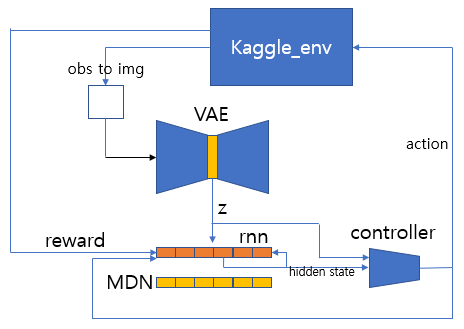

In [ ]:
%%write_and_run -a main.py 
def prevent_opposite_action(action, prev_action):
    opposite_action = {'NORTH':'SOUTH' , 'SOUTH':'NORTH', 'EAST':'WEST', 'WEST':'EAST' }
    if prev_action is not None:
        if opposite_action[prev_action] == "NORTH":
            action[:,0] = float("-Inf")
        if opposite_action[prev_action] == "SOUTH":
            action[:,1] = float("-Inf")
        if opposite_action[prev_action] == "WEST":
            action[:,2] = float("-Inf")
        if opposite_action[prev_action] == "EAST":
            action[:,3] = float("-Inf")
    return action

In [ ]:
def evaluate_control_model(vae, rnn, controller, device):
    dir2code = {"NORTH":torch.Tensor([1,0,0,0]), "SOUTH": torch.Tensor([0,1,0,0]), 
                "WEST":torch.Tensor([0,0,1,0]), "EAST": torch.Tensor([0,0,0,1])}
    code2dir = ["NORTH", "SOUTH", "WEST", "EAST"]
    env = make("hungry_geese", debug=False) 
    trainer = env.train([None, "greedy", "greedy", "greedy"])
    total_episodes = 20
    time_steps = 200
    s = 0
    cumulative = 0
    cumulative_ = 0
    mdrnn = MDRNNCell(latents, actions, hiddens, gaussians).to(device)
    
    while s < total_episodes:
        obs = trainer.reset()
        img = custom_env_render(obs, True)
        action = torch.zeros(1, actions).to(device)
        reward_ = torch.zeros(1, 1).to(device)
        hidden = [torch.zeros(1, hiddens).to(device) for _ in range(2)]
        
        rnn_state = torch.load('MDN_RNN.pt')
        prev_action = None
        for t in range(time_steps): 
            _, mu, log_var = vae(img.unsqueeze(0).to(device))
            sigma = log_var.exp()
            eps = torch.randn_like(sigma)
            z = eps.mul(sigma).add_(mu)
            mdrnn.load_state_dict({k.strip('_l0'): v for k, v in rnn_state.items()})

            rnn_input = torch.cat((z, action, reward_), -1)
            out_full, hidden = mdrnn(rnn_input, hidden)
            
            c_in = torch.cat((z, hidden[1]),-1)
            controller.to(device)
            action = controller(c_in)
            action = action.detach().to('cpu')
            action = prevent_opposite_action(action, prev_action)
            prob = F.softmax(action.squeeze(0)/0.7, dim=0).numpy()
            action_dir = np.random.choice(code2dir, p=prob)
            
            obs, reward, done, info = trainer.step(action_dir)
            reward = custom_reward(obs)
            prev_action = action_dir
            action = dir2code[action_dir]
            img = custom_env_render(obs)
            reward = torch.Tensor([[reward * (1-int(done))]])
            #reward = torch.where(reward > 0 , 1, 0)
            action = action.unsqueeze(0).to(device)
            cumulative += reward
            if done:
                obs = trainer.reset()
                break
        
        cumulative_ += cumulative
        s+=1
    cumulative_ = cumulative / s
    return float(cumulative_)

# Controller Evaluation in Dream env 

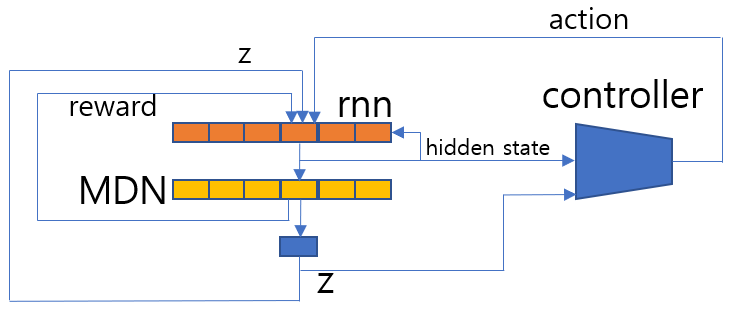

Training controller in environment made by MDN-RNN

observation image and reward from kaggle environment is replaced by MDN's output (z vector and reward)

In [ ]:
def get_mixture_coef(z_pred):
    log_pi, mu, log_sigma = torch.split(z_pred, 5, 1)
    log_pi = log_pi - torch.log(torch.sum(torch.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma

def get_pi_idx(x, pdf):
    # samples from a categorial distribution
    N = pdf.size()
    accumulate = 0
    for i in range(0, N[0]):
        accumulate += pdf[i]
        if (accumulate >= x):
            return i
    random_value = np.random.randint(N)
    #print('error with sampling ensemble, returning random', random_value)
    return random_value

def sample_z(mu, log_sigma):
    z =  mu + (torch.exp(log_sigma)) * torch.randn(*log_sigma.shape) 
    return z


def get_z_from_rnn_output(y_pred):
    HIDDEN_UNITS = 256
    GAUSSIAN_MIXTURES = 5
    Z_DIM = 32
    d = GAUSSIAN_MIXTURES * Z_DIM

    z_pred = y_pred[:,:(3*d)]
    rew_pred = y_pred[:,-1]
    z_pred = torch.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])

    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    chosen_log_pi = torch.zeros(Z_DIM)
    chosen_mu = torch.zeros(Z_DIM)
    chosen_log_sigma = torch.zeros(Z_DIM)

    # adjust temperatures
    logmix2 = log_pi
    logmix2 -= logmix2.max()
    logmix2 = torch.exp(logmix2)
    logmix2 /= logmix2.sum(axis=1).reshape(Z_DIM, 1)


    for j in range(Z_DIM):
        idx = get_pi_idx(np.random.rand(), logmix2[j])
        chosen_log_pi[j] = idx
        chosen_mu[j] = mu[j, idx]
        chosen_log_sigma[j] = log_sigma[j,idx]

    next_z = sample_z(chosen_mu, chosen_log_sigma)
    
    # custom reward output for CMA-es
    next_reward = F.sigmoid(rew_pred)
    """
    if rew_pred > 0:
        next_reward = 1
    else:
        next_reward = 0
    """    
    return next_z, next_reward, chosen_mu

In [ ]:
def evaluate_control_model_dream(vae, rnn, controller, device):
    dir2code = {"NORTH":torch.Tensor([1,0,0,0]), "SOUTH": torch.Tensor([0,1,0,0]), 
                "WEST":torch.Tensor([0,0,1,0]), "EAST": torch.Tensor([0,0,0,1])}
    code2dir = ["NORTH", "SOUTH", "WEST", "EAST"]
    total_episodes = 10
    time_steps = 200
    s = 0
    cumulative = 0
    cumulative_ = 0
    mdrnn = MDRNNCell(latents, actions, hiddens, gaussians).to(device)
    env = make("hungry_geese", debug=False) 
    trainer = env.train([None, "greedy", "greedy", "greedy"])
    while s < total_episodes:
        # make initiate observation
        obs = trainer.reset()
        img = custom_env_render(obs, True)
        _, mu, log_var = vae(img.unsqueeze(0).to(device))
        sigma = log_var.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu)
        obs = trainer.reset()
        
        action = torch.zeros(1, actions).to(device)
        reward_ = torch.zeros(1, 1).to(device)
        
        hidden = [torch.zeros(1, hiddens).to(device) for _ in range(2)]
        prev_action = None
        rnn_state = torch.load('MDN_RNN.pt')
        for t in range(time_steps): 
            mdrnn.load_state_dict({k.strip('_l0'): v for k, v in rnn_state.items()})
            rnn_input = torch.cat((z, action, reward_), -1)
            out, hidden = mdrnn(rnn_input, hidden)
            
            z, reward, mu = get_z_from_rnn_output(out)
            z = z.to(device)
            c_in = torch.cat((z, hidden[1].squeeze(0)),-1)
            action = controller(c_in)
            action = action.unsqueeze(0).detach().to('cpu')
            action = prevent_opposite_action(action, prev_action)
            prob = F.softmax(action.squeeze(0)/0.7, dim=0).numpy()
            action_dir = np.random.choice(code2dir, p=prob)
            prev_action = action_dir
            action = dir2code[action_dir]
            z = z.unsqueeze(0)
            action = action.unsqueeze(0).to(device)
            if reward_==0 and t>0:
                print('break in step:{}'.format(t))
                break
            cumulative += reward_
            reward_ = torch.Tensor([[reward]]).to(device)
        
        cumulative_ += cumulative
        s+=1
    cumulative_ = cumulative / s
    
    return float(cumulative_)


In [ ]:
def flatten_parameters(params):
    return torch.cat([p.detach().view(-1) for p in params], dim=0).to('cpu').numpy()

In [ ]:
def unflatten_parameters(params, example, device):

    params = torch.Tensor(params).to(device)
    idx = 0
    unflattened = []
    for e_p in example:
        unflattened += [params[idx:idx + e_p.numel()].view(e_p.size())]
        idx += e_p.numel()
    return unflattened

def load_parameters(params, controller):

    proto = next(controller.parameters())
    params = unflatten_parameters(
        params, controller.parameters(), proto.device)

    for p, p_0 in zip(controller.parameters(), params):
        p.data.copy_(p_0)

# Train Contoller with CMA Evolution Strategy

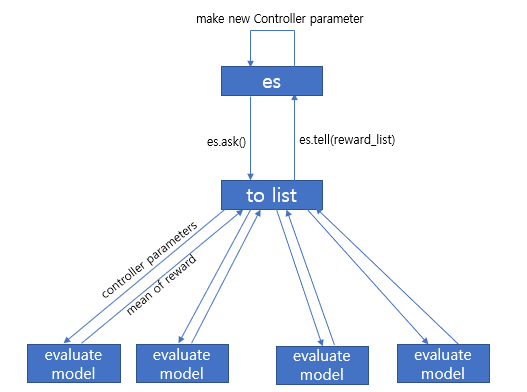

In [ ]:
def train_controller(controller, vae, rnn,  mode='real'):
    parameters = controller.parameters()
    es = cma.CMAEvolutionStrategy(flatten_parameters(parameters), 0.1,
                                  {'popsize': 32})

    vae = vae.to(device)
    rnn = rnn.to(device)
    start_time = time.time()
    epoch = 0
    best = 0.0
    cur_best = None
    epochs = 8

    while not es.stop():
        print('epoch : {}'.format(epoch))
        solutions = es.ask()
        reward_list = []
        for s_idx, s in enumerate(solutions):
            load_parameters(s, controller)
            if mode == 'real':
                reward = evaluate_control_model(vae, rnn, controller, device)
            elif mode == 'dream':
                reward = evaluate_control_model_dream(vae, rnn, controller, device)

            reward_list.append(reward)
        es.tell(solutions, reward_list)
        es.disp()

        cur_best = max(reward_list)
        best_index = np.argmax(reward_list)
        best_params = solutions[best_index]
        print('current best reward : {}'.format(cur_best))
        if not best or cur_best >= best:
            best = cur_best
            print("Saving new best with value {}...".format(cur_best))
            load_parameters(best_params, controller)
            if mode == 'real':
                torch.save(controller.state_dict(), 'controller.pt')
            elif mode == 'dream':
                torch.save(controller.state_dict(), 'controller_dream.pt')

        epoch += 1
        if epoch > epochs:
            break


    es.result_pretty()

In [ ]:
#train controller in real env
train_controller(controller, vae, rnn, 'real')

In [ ]:
#train controller in dream
train_controller(controller, vae, rnn, 'dream')

In [ ]:
import shutil
shutil.copy('main.py', 'main_nodream.py')

In [ ]:
%%writefile -a main.py
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
ACTIONS = [a for a in Action]
import sys
import os

sys.path.append("/kaggle_simulations/agent")

prev_action = None

action_ = torch.zeros(1, 4)
reward_ = torch.zeros(1, 1)
hidden = [torch.zeros(1, 256) for _ in range(2)]



def agent(obs, config):
    global action_, reward_, hidden, prev_action
    dir2code = {"NORTH":torch.Tensor([1,0,0,0]), "SOUTH": torch.Tensor([0,1,0,0]), 
                "WEST":torch.Tensor([0,0,1,0]), "EAST": torch.Tensor([0,0,0,1])}
    code2dir = ["NORTH", "SOUTH", "WEST", "EAST"]
    dir2action = {"NORTH":ACTIONS[0].name, "EAST":ACTIONS[1].name, "SOUTH":ACTIONS[2].name, "WEST":ACTIONS[3].name}

    device = torch.device('cpu') 
    latents = 32
    actions = 4
    hiddens = 256
    gaussians = 5
    
    vae = VAE(latents)
    controller = Controller(latents, hiddens, actions)
    mdrnn = MDRNNCell(latents, actions, hiddens, gaussians)
    if os.path.exists('/kaggle_simulations/agent/vae.pt'):
        vae.load_state_dict(torch.load('/kaggle_simulations/agent/vae.pt',map_location=torch.device('cpu')))
        rnn_state = torch.load('/kaggle_simulations/agent/MDN_RNN.pt',map_location=torch.device('cpu'))    
        #use controller model trained in dream environment
        controller.load_state_dict(torch.load('/kaggle_simulations/agent/controller_dream.pt',map_location=torch.device('cpu')))
        
    else:
        vae.load_state_dict(torch.load('vae.pt'))
        rnn_state = torch.load('MDN_RNN.pt')    
        #use controller model trained in dream environment
        controller.load_state_dict(torch.load('controller_dream.pt'))    
    
    mdrnn.load_state_dict({k.strip('_l0'): v for k, v in rnn_state.items()})

    img = custom_env_render(obs, True)
    reward_[0][0] = custom_reward(obs)
    _, mu, log_var = vae(img.unsqueeze(0))
    sigma = log_var.exp()
    eps = torch.randn_like(sigma)
    z = eps.mul(sigma).add_(mu)
    rnn_input = torch.cat((z, action_, reward_), -1)
    
    out_full, hidden = mdrnn(rnn_input, hidden)
    
    c_in = torch.cat((z, hidden[1]),-1)
    action_ = controller(c_in)
    action_ = prevent_opposite_action(action_.detach(), prev_action)
    prob = F.softmax(action_.squeeze(0)/0.7, dim=0).numpy()
    action_dir = np.random.choice(code2dir, p=prob)
    action_ = dir2code[action_dir].unsqueeze(0)
    prev_action = action_dir
    return dir2action[action_dir]

In [ ]:
env = make("hungry_geese", debug=True)

env.reset()
env.run(["main.py", "main.py", "main.py", "main.py"])
env.render(mode="ipython", width=640, height=480)

In [ ]:
%%writefile -a main_nodream.py
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import sys
import os

sys.path.append("/kaggle_simulations/agent")

ACTIONS = [a for a in Action]
prev_action = None
action_ = torch.zeros(1, 4)
reward_ = torch.zeros(1, 1)
hidden = [torch.zeros(1, 256) for _ in range(2)]
def agent(obs, config):
    
    global action_, reward_, hidden, prev_action
    dir2code = {"NORTH":torch.Tensor([1,0,0,0]), "SOUTH": torch.Tensor([0,1,0,0]), 
                "WEST":torch.Tensor([0,0,1,0]), "EAST": torch.Tensor([0,0,0,1])}
    code2dir = ["NORTH", "SOUTH", "WEST", "EAST"]
    dir2action = {"NORTH":ACTIONS[0].name, "EAST":ACTIONS[1].name, "SOUTH":ACTIONS[2].name, "WEST":ACTIONS[3].name}
    
    device = torch.device('cpu') 
    latents = 32
    actions = 4
    hiddens = 256
    gaussians = 5
    vae = VAE(latents)
    controller = Controller(latents, hiddens, actions)
    
    mdrnn = MDRNNCell(latents, actions, hiddens, gaussians)
    if os.path.exists('/kaggle_simulations/agent/vae.pt'):
        vae.load_state_dict(torch.load('/kaggle_simulations/agent/vae.pt',map_location=torch.device('cpu')))
        rnn_state = torch.load('/kaggle_simulations/agent/MDN_RNN.pt',map_location=torch.device('cpu'))
        #use controller model trained in dream environment
        controller.load_state_dict(torch.load('/kaggle_simulations/agent/controller.pt',map_location=torch.device('cpu')))
    else:
        vae.load_state_dict(torch.load('vae.pt'))
        rnn_state = torch.load('MDN_RNN.pt')
        #use controller model trained in dream environment
        controller.load_state_dict(torch.load('controller.pt'))
        
    mdrnn.load_state_dict({k.strip('_l0'): v for k, v in rnn_state.items()})

    img = custom_env_render(obs, True)
    reward_[0][0] = custom_reward(obs)
    _, mu, log_var = vae(img.unsqueeze(0))
    sigma = log_var.exp()
    eps = torch.randn_like(sigma)
    z = eps.mul(sigma).add_(mu)
    rnn_input = torch.cat((z, action_, reward_), -1)
    
    out_full, hidden = mdrnn(rnn_input, hidden)
    
    c_in = torch.cat((z, hidden[1]),-1)
    action_ = controller(c_in)
    action_ = prevent_opposite_action(action_, prev_action)
    prob = F.softmax(action_.squeeze(0)/0.7, dim=0).detach().numpy()
    action_dir = np.random.choice(code2dir, p=prob)
    action_ = dir2code[action_dir].unsqueeze(0)
    prev_action = action_dir
    return dir2action[action_dir]

In [ ]:
env = make("hungry_geese", debug=True)

env.reset()
env.run(["main_nodream.py", "main_nodream.py", "main_nodream.py", "main_nodream.py"])
env.render(mode="ipython", width=640, height=480)

In [ ]:
!tar cvfz sub.tar.gz main.py 'vae.pt' 'controller_dream.pt' 'MDN_RNN.pt'

In [ ]:
from shutil import move
move('main_nodream.py', 'main.py')

In [ ]:
!tar cvfz sub_nodream.tar.gz main.py 'vae.pt' 'controller.pt' 'MDN_RNN.pt'